# 1. Dataset Description

In [1]:
# -----------------------------
# Dataset Description
# -----------------------------
# This dataset contains loan application records with both numerical and categorical features.
# Target variable:
# - loan_status: Indicates whether the loan was repaid (1) or not (0)

# Numerical Features:
# - person_age: Age of the applicant
# - person_income: Applicant's annual income
# - person_emp_length: Length of employment (in years)
# - loan_amnt: Loan amount requested
# - loan_int_rate: Interest rate of the loan
# - loan_percent_income: Ratio of loan amount to income
# - cb_person_cred_hist_length: Credit history length (in years)

# Categorical Features:
# - person_home_ownership: Type of home ownership ['RENT', 'MORTGAGE', 'OWN', 'OTHER']
# - loan_intent: Purpose of the loan ['EDUCATION', 'MEDICAL', 'VENTURE', 'PERSONAL', 'HOMEIMPROVEMENT', 'DEBTCONSOLIDATION']
# - cb_person_default_on_file: Whether the person has defaulted before ['Y', 'N']
# - loan_grade: Credit grade assigned to the loan ['A', 'B', 'C', 'D', 'E', 'F', 'G']

# Notes:
# - The dataset may contain missing values and requires preprocessing (e.g., imputation).
# - Use proper encoding for categorical features before model training.
# - Submissions are evaluated using area under the ROC curve (AUC) based on predicted probabilities and ground truth targets.


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Modeling & Evaluation
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    cross_val_predict
)
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score,
    roc_auc_score
)

# Models
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    StackingClassifier
)
from xgboost import XGBClassifier
from sklearn.linear_model import (
    LogisticRegression,
    LinearRegression,
    ElasticNetCV
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVR

# EDA tools
from lazypredict.Supervised import LazyClassifier
from ydata_profiling import ProfileReport


# 2. Preprocessing data

In [26]:
# import data
train1 = pd.read_csv("C:/Users/YOGA 7/Downloads/train (1).csv")
test = pd.read_csv("C:/Users/YOGA 7/Downloads/test (1).csv")
original = pd.read_csv("C:/Users/YOGA 7/Downloads/credit_risk_dataset.csv")

train = pd.concat([train1, original], ignore_index=True)

In [27]:
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0.00,NaN,NaN,RENT,0.00,NaN,NaN,NaN,NaN,0.17,N,14,0
1,1.00,22.00,56000.00,OWN,6.00,MEDICAL,C,4000.00,13.35,0.07,N,2,0
2,2.00,29.00,28800.00,OWN,8.00,PERSONAL,A,6000.00,8.90,0.21,N,10,0
3,3.00,30.00,70000.00,RENT,14.00,VENTURE,B,12000.00,11.11,0.17,N,5,0
4,4.00,22.00,60000.00,RENT,2.00,MEDICAL,A,6000.00,6.92,0.10,N,3,0


In [28]:
# drop duplicates
train = train.drop_duplicates()
test = test.drop_duplicates()

# drop id column
train = train.drop("id", axis=1)
test = test.drop("id", axis=1)

In [29]:
#check information
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91061 entries, 0 to 91225
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91060 non-null  float64
 1   person_income               91060 non-null  float64
 2   person_home_ownership       91061 non-null  object 
 3   person_emp_length           90174 non-null  float64
 4   loan_intent                 91060 non-null  object 
 5   loan_grade                  91060 non-null  object 
 6   loan_amnt                   91060 non-null  float64
 7   loan_int_rate               87965 non-null  float64
 8   loan_percent_income         91061 non-null  float64
 9   cb_person_default_on_file   91061 non-null  object 
 10  cb_person_cred_hist_length  91061 non-null  int64  
 11  loan_status                 91061 non-null  int64  
dtypes: float64(6), int64(2), object(4)
memory usage: 9.0+ MB
<class 'pandas.core.frame.DataFrame'

In [30]:
# # Describe data = summary + visualization
# profile = ProfileReport(train, title="Loan Approval Report", explorative=True)
# profile.to_file("kaggle.html")

In [31]:
# Check missing value
print("Missing values in TRAIN:")
print(train.isnull().sum())

print("\nMissing values in TEST:")
print(test.isnull().sum())


Missing values in TRAIN:
person_age                       1
person_income                    1
person_home_ownership            0
person_emp_length              887
loan_intent                      1
loan_grade                       1
loan_amnt                        1
loan_int_rate                 3096
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64

Missing values in TEST:
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


In [10]:
# Fill missing value
# Identify numerical and categorical columns
numerical_cols = train.select_dtypes(include=['number']).columns.drop('loan_status', errors='ignore')
categorical_cols = train.select_dtypes(exclude=['number']).columns

# Define imputers for missing values
num_imputer = SimpleImputer(strategy='mean')               # Use mean for numerical columns
cat_imputer = SimpleImputer(strategy='most_frequent')      # Use most frequent value for categorical columns

# Fit and transform the training data
train[numerical_cols] = num_imputer.fit_transform(train[numerical_cols])
train[categorical_cols] = cat_imputer.fit_transform(train[categorical_cols])

# Transform the test data using the same imputers
test[numerical_cols] = num_imputer.transform(test[numerical_cols])
test[categorical_cols] = cat_imputer.transform(test[categorical_cols])

In [11]:
# ReCheck missing value
print("Missing values in TRAIN:")
print(train.isnull().sum())

print("\nMissing values in TEST:")
print(test.isnull().sum())


Missing values in TRAIN:
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

Missing values in TEST:
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


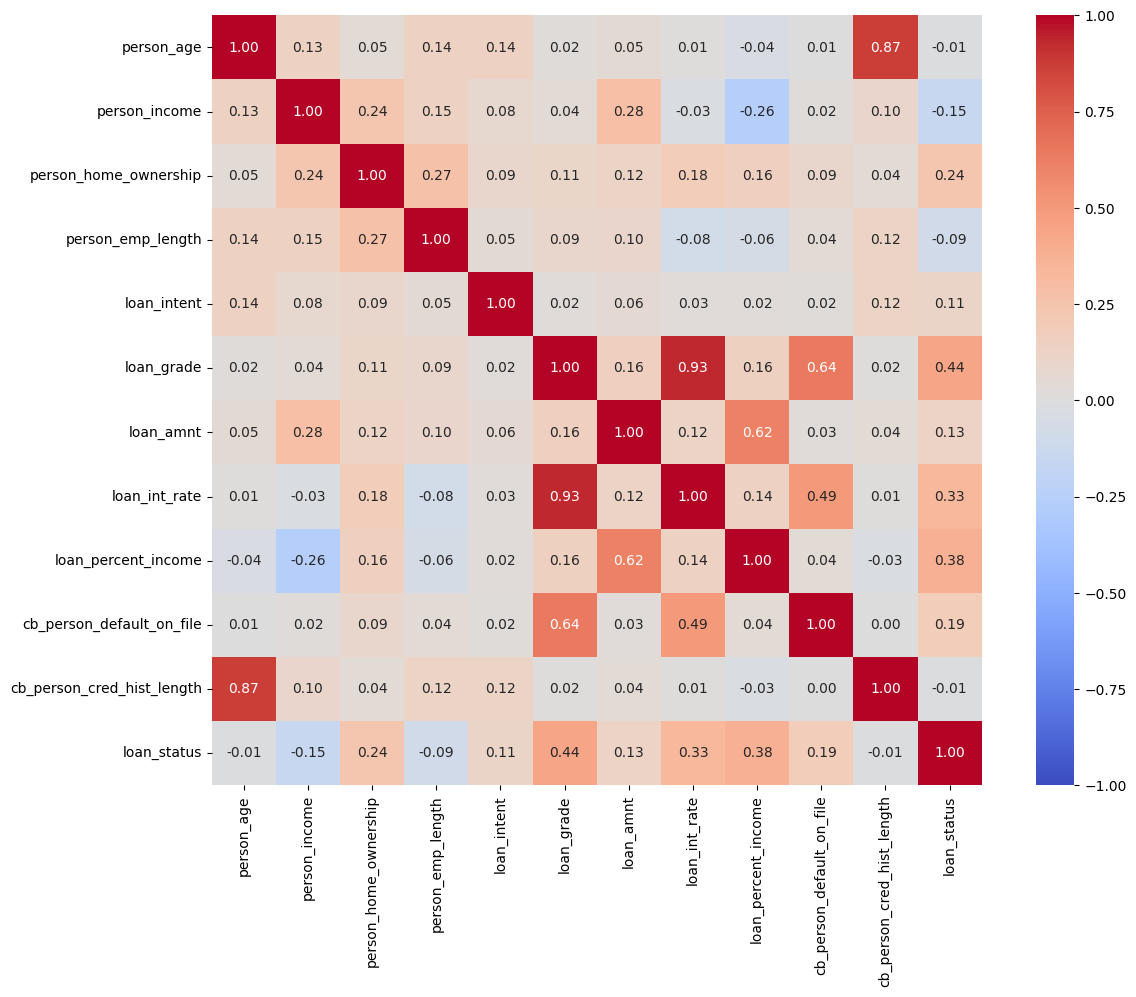

In [12]:
# Correlation - heatmap
from dython.nominal import associations

# Vẽ heatmap tương quan hỗn hợp
associations(train, figsize=(14,10), cmap="coolwarm", annot=True)
plt.show()


In [32]:
# Split dataset into features and target
X_train = train.drop('loan_status', axis=1)
y_train = train['loan_status']

In [14]:
# LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to each categorical column in both train and test
for col in categorical_cols:
    # Fit encoder on train data
    le.fit(X_train[col])
    # Transform train and test data
    X_train[col] = le.transform(X_train[col])
    test[col] = le.transform(test[col])

In [15]:
# StandardScaler
scaler = StandardScaler()

# Fit scaler on training features and transform both train and test
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
test = pd.DataFrame(scaler.transform(test), columns=test.columns)

# 3. Model Optimizing 

In [ ]:
# 3. Split data into training and validation sets (20% for validation)
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 4. Initialize LazyClassifier with parallel processing
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, predictions=True)

# 5. Fit LazyClassifier to compare classification models on training vs validation sets
models, predictions = clf.fit(X_train1, X_val, y_train1, y_val)

# Display model comparison results
models


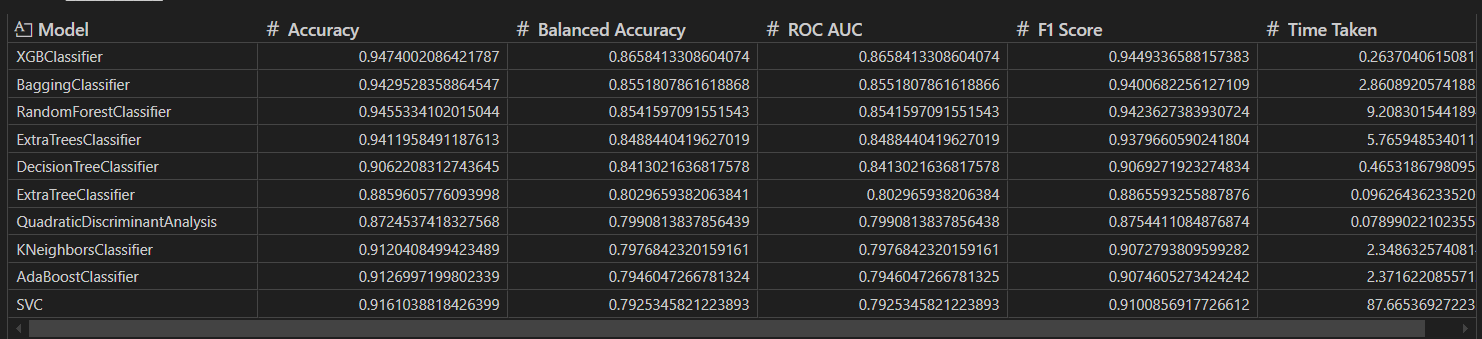

In [16]:
# Stratified K-Fold CV
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [17]:
rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print("🔸 Random Forest - Best Params:", grid_rf.best_params_)
print("🔸 Random Forest - Mean CV AUC: {:.4f}".format(grid_rf.best_score_))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
🔸 Random Forest - Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
🔸 Random Forest - Mean CV AUC: 0.9416


In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.05]
}

grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
print("🔸 XGBoost - Best Params:", grid_xgb.best_params_)
print("🔸 XGBoost - Mean CV AUC: {:.4f}".format(grid_xgb.best_score_))


In [ ]:
bag = BaggingClassifier(random_state=42)

param_grid_bag = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0]
}

grid_bag = GridSearchCV(
    estimator=bag,
    param_grid=param_grid_bag,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_bag.fit(X_train, y_train)
best_bag = grid_bag.best_estimator_
print("🔸 Bagging - Best Params:", grid_bag.best_params_)
print("🔸 Bagging - Mean CV AUC: {:.4f}".format(grid_bag.best_score_))


### 🔍 Grid Search Results Summary (5-Fold Cross Validation)

Each model was tuned with 5-fold cross-validation using `GridSearchCV`. A total of 60 fits were performed per model.

---

#### 🌲 Random Forest
- **Best Parameters**:  
  `{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}`
- **Mean CV AUC**: **0.9416**

---

#### ⚡ XGBoost Classifier
- **Best Parameters**:  
  `{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}`
- **Mean CV AUC**: **0.9560**

---

#### 🎒 Bagging Classifier
- **Best Parameters**:  
  `{'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 100}`
- **Mean CV AUC**: **0.9477**


In [20]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score

def rf_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300, step=50),
        "max_depth": trial.suggest_int("max_depth", 5, 30, step=5),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10)
    }
    model = RandomForestClassifier(**params, random_state=42)
    auc_scores = cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=cv_strategy, n_jobs=-1)
    return np.mean(auc_scores)

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(rf_objective, n_trials=20)

[I 2025-06-06 17:23:43,297] A new study created in memory with name: no-name-3d3d94ec-81e4-4e95-a72f-d550c452d78c
[I 2025-06-06 17:23:56,036] Trial 0 finished with value: 0.9368786195053784 and parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 10}. Best is trial 0 with value: 0.9368786195053784.
[I 2025-06-06 17:24:19,128] Trial 1 finished with value: 0.9278994565977092 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 6}. Best is trial 0 with value: 0.9368786195053784.
[I 2025-06-06 17:24:31,386] Trial 2 finished with value: 0.9274978564143168 and parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 9}. Best is trial 0 with value: 0.9368786195053784.
[I 2025-06-06 17:25:05,280] Trial 3 finished with value: 0.9420768377106494 and parameters: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 9}. Best is trial 3 with value: 0.9420768377106494.
[I 2025-06-06 17:25:19,662] Trial 4 finished with value: 0.9278340469

In [24]:
def xgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 400, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3)
    }
    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', random_state=42)
    auc_scores = cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=cv_strategy, n_jobs=-1)
    return np.mean(auc_scores)

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(xgb_objective, n_trials=20)


[I 2025-06-06 17:32:24,297] A new study created in memory with name: no-name-fca17178-d49a-4092-8efe-afc88c93ad8f
[I 2025-06-06 17:32:26,902] Trial 0 finished with value: 0.9556304089747819 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.09323515112117592}. Best is trial 0 with value: 0.9556304089747819.
[I 2025-06-06 17:32:28,954] Trial 1 finished with value: 0.9565145055328585 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2312050447853527}. Best is trial 1 with value: 0.9565145055328585.
[I 2025-06-06 17:32:32,719] Trial 2 finished with value: 0.9498362988961171 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.2795733442355707}. Best is trial 1 with value: 0.9565145055328585.
[I 2025-06-06 17:32:35,050] Trial 3 finished with value: 0.9567923695626306 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.13640347299819125}. Best is trial 3 with value: 0.9567923695626306.
[I 2025-06-06 17:32:

In [25]:
def bagging_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200, step=50),
        "max_samples": trial.suggest_float("max_samples", 0.5, 1.0),
        "max_features": trial.suggest_float("max_features", 0.3, 1.0)
    }
    model = BaggingClassifier(**params, random_state=42)
    auc_scores = cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=cv_strategy, n_jobs=-1)
    return np.mean(auc_scores)

study_bag = optuna.create_study(direction="maximize")
study_bag.optimize(bagging_objective, n_trials=20)


[I 2025-06-06 17:34:03,126] A new study created in memory with name: no-name-9ad56c88-3134-40f5-924a-1040af6f0bb4
[I 2025-06-06 17:34:17,699] Trial 0 finished with value: 0.9475568390421995 and parameters: {'n_estimators': 100, 'max_samples': 0.8919606066377399, 'max_features': 0.4560551728545248}. Best is trial 0 with value: 0.9475568390421995.
[I 2025-06-06 17:34:22,132] Trial 1 finished with value: 0.9349182200902855 and parameters: {'n_estimators': 50, 'max_samples': 0.8717219758158272, 'max_features': 0.32243925191396355}. Best is trial 0 with value: 0.9475568390421995.
[I 2025-06-06 17:34:34,869] Trial 2 finished with value: 0.9437375817984982 and parameters: {'n_estimators': 50, 'max_samples': 0.6723764910423737, 'max_features': 0.9570962532154161}. Best is trial 0 with value: 0.9475568390421995.
[I 2025-06-06 17:35:14,009] Trial 3 finished with value: 0.9493761254622639 and parameters: {'n_estimators': 200, 'max_samples': 0.6633656690777507, 'max_features': 0.7534883084924489}.

### ✅ Optuna Tuning Results (5-Fold CV AUC)

Each model was optimized using Optuna with 5-fold cross-validation (`cv_strategy`).  
The best result among 20 trials was selected for each model.

---

#### 🌲 Random Forest
- **Best Parameters**:  
  `{'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10}`
- **Best Mean CV AUC**: **0.9425**

---

#### ⚡ XGBoost Classifier
- **Best Parameters**:  
  `{'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.0614}`
- **Best Mean CV AUC**: **0.9569**

---

#### 🎒 Bagging Classifier
- **Best Parameters**:  
  `{'n_estimators': 150, 'max_samples': 0.5499, 'max_features': 0.6455}`
- **Best Mean CV AUC**: **0.9501**
""")

# 4. Model stacking

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier

# 1. Define base models with best Optuna parameters
rf_clf = RandomForestClassifier(
    n_estimators=200, max_depth=20, min_samples_split=10, random_state=42
)

xgb_clf = XGBClassifier(
    n_estimators=200, max_depth=4, learning_rate=0.06141888282288244,
    use_label_encoder=False, eval_metric='logloss', random_state=42
)

bagging_clf = BaggingClassifier(
    n_estimators=150, max_samples=0.5498882953602721,
    max_features=0.6454661339378821, random_state=42
)

# 2. Meta-model: MLP
meta_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# 3. Define full CV strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Define stacking classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf_clf),
        ('xgb', xgb_clf),
        ('bagging', bagging_clf)
    ],
    final_estimator=meta_model,
    cv=cv_strategy,
    n_jobs=-1,
    passthrough=False
)

# 5. Cross-validated prediction on full training set
y_pred_proba = cross_val_predict(
    stacking_clf, X_train, y_train,
    cv=cv_strategy, method='predict_proba', n_jobs=-1
)[:, 1]

# 6. Calculate AUC
auc_score = roc_auc_score(y_train, y_pred_proba)
print(f"Cross-validated AUC for Stacking Model (full CV): {auc_score:.4f}")

In [ ]:
# 1. Define base models with best Optuna parameters
rf_clf = RandomForestClassifier(
    n_estimators=200, max_depth=20, min_samples_split=10, random_state=42
)

xgb_clf = XGBClassifier(
    n_estimators=200, max_depth=4, learning_rate=0.0614,
    use_label_encoder=False, eval_metric='logloss', random_state=42
)

bagging_clf = BaggingClassifier(
    n_estimators=150, max_samples=0.5499, max_features=0.6455, random_state=42
)

# 2. Meta-model: XGBoost 
meta_model = XGBClassifier(
    n_estimators=100, learning_rate=0.05, max_depth=3,
    use_label_encoder=False, eval_metric='logloss', random_state=42
)

# 3. Define CV strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Define stacking classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf_clf),
        ('xgb', xgb_clf),
        ('bagging', bagging_clf)
    ],
    final_estimator=meta_model,
    cv=cv_strategy,
    n_jobs=-1,
    passthrough=False
)

# 5. Cross-validated prediction on full training set
y_pred_proba = cross_val_predict(
    stacking_clf, X_train, y_train,
    cv=cv_strategy, method='predict_proba', n_jobs=-1
)[:, 1]

# 6. Calculate AUC
auc_score = roc_auc_score(y_train, y_pred_proba)
print(f"Cross-validated AUC with XGB meta-model: {auc_score:.4f}")


Cross-validated AUC with XGB meta-model: 0.9525


In [ ]:
# 1. Define base models with Grid Search best parameters
rf_clf = RandomForestClassifier(
    n_estimators=200, max_depth=20, min_samples_split=5, random_state=42
)

xgb_clf = XGBClassifier(
    n_estimators=300, max_depth=5, learning_rate=0.1,
    use_label_encoder=False, eval_metric='logloss', random_state=42
)

bagging_clf = BaggingClassifier(
    n_estimators=100, max_samples=1.0, max_features=0.5, random_state=42
)

# 2. Meta-model: XGBoost 
meta_model = XGBClassifier(
    n_estimators=100, learning_rate=0.05, max_depth=3,
    use_label_encoder=False, eval_metric='logloss', random_state=42
)

# 3. Define CV strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Define stacking classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf_clf),
        ('xgb', xgb_clf),
        ('bagging', bagging_clf)
    ],
    final_estimator=meta_model,
    cv=cv_strategy,
    n_jobs=-1,
    passthrough=False
)

# 5. Cross-validated prediction on full training set
y_pred_proba = cross_val_predict(
    stacking_clf, X_train, y_train,
    cv=cv_strategy, method='predict_proba', n_jobs=-1
)[:, 1]

# 6. Calculate AUC
auc_score = roc_auc_score(y_train, y_pred_proba)
print(f"Cross-validated AUC with XGB meta-model: {auc_score:.4f}")

Cross-validated AUC with XGB meta-model: 0.9579


In [12]:
from sklearn.metrics import roc_auc_score, accuracy_score

# 5a. Cross-validated prediction (probability) để tính AUC
y_pred_proba = cross_val_predict(
    stacking_clf, X_train, y_train,
    cv=cv_strategy, method='predict_proba', n_jobs=-1
)[:, 1]

auc_score = roc_auc_score(y_train, y_pred_proba)
print(f"Cross-validated AUC with XGB meta-model: {auc_score:.4f}")

# 5b. Cross-validated prediction (labels) để tính Accuracy
y_pred = cross_val_predict(
    stacking_clf, X_train, y_train,
    cv=cv_strategy, method='predict', n_jobs=-1
)

accuracy = accuracy_score(y_train, y_pred)
print(f"Cross-validated Accuracy with XGB meta-model: {accuracy:.4f}")


Cross-validated AUC with XGB meta-model: 0.9579
Cross-validated Accuracy with XGB meta-model: 0.9468


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

# 1. Split X_train, y_train into training and validation sets
X_train_en, X_val_en, y_train_en, y_val_en = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# 2. Define stacking model with XGB as meta model
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=200, random_state=42)),
        ('xgb', XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=300, use_label_encoder=False, eval_metric='logloss', random_state=42)),
        ('bagging', BaggingClassifier(max_features=0.5, max_samples=1.0, n_estimators=100, random_state=42))
    ],
    final_estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    passthrough=False
)

# 3. Fit stacking model on training set
stacking_clf.fit(X_train_en, y_train_en)

# 4. Predict probabilities on validation set
y_val_pred_proba = stacking_clf.predict_proba(X_val_en)[:, 1]

# 5. Calculate AUC on validation set
auc_val = roc_auc_score(y_val_en, y_val_pred_proba)
print(f"Validation AUC for Stacking Model (XGB meta model): {auc_val:.4f}")


Validation AUC for Stacking Model (XGB meta model): 0.9531


# Choose Grid Search best parameters and Optuna best parameters / Meta model is XGB
# 5. Submit

In [34]:
# 1. Fit stacking model on the full training set
stacking_clf.fit(X_train, y_train)

# 2. Predict probabilities on the test dataset
y_test_pred_proba = stacking_clf.predict_proba(test)[:, 1]

# 3. Load the sample submission CSV file
submission = pd.read_csv(r"C:\Users\YOGA 7\Downloads\sample_submission (1).csv")

# 4. Replace the values in the 'loan_status' column with predicted probabilities
submission['loan_status'] = y_test_pred_proba

# 5. Save the updated submission file
submission.to_csv(r"C:\Users\YOGA 7\Downloads\subfinal2.csv", index=False)


# Bonus: ScoreCard Modeling

In [33]:
X_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,NaN,NaN,RENT,0.00,NaN,NaN,NaN,NaN,0.17,N,14
1,22.00,56000.00,OWN,6.00,MEDICAL,C,4000.00,13.35,0.07,N,2
2,29.00,28800.00,OWN,8.00,PERSONAL,A,6000.00,8.90,0.21,N,10
3,30.00,70000.00,RENT,14.00,VENTURE,B,12000.00,11.11,0.17,N,5
4,22.00,60000.00,RENT,2.00,MEDICAL,A,6000.00,6.92,0.10,N,3


In [34]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: loan_status, dtype: int64

In [ ]:
import scorecardpy as sc
from sklearn.linear_model import LogisticRegression

# Nối lại dữ liệu train để xử lý woe
train_woe = X_train.copy()
train_woe['loan_status'] = y_train

# Step 1: Chia bin cho tất cả biến
bins = sc.woebin(train_woe, y='loan_status')

# Step 2: Áp dụng woe transform lên dữ liệu
train_woe_transformed = sc.woebin_ply(train_woe, bins)
test_woe_transformed = sc.woebin_ply(test, bins)

# Tách lại đặc trưng và mục tiêu
X_train_woe = train_woe_transformed.drop(columns='loan_status')
y_train_woe = train_woe_transformed['loan_status']



[INFO] creating woe binning ...
Binning on 91061 rows and 12 columns in 00:00:11
[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [36]:
# Huấn luyện Logistic Regression trên tập dữ liệu đã WOE
lr_model = LogisticRegression(max_iter=1000, solver='lbfgs')
lr_model.fit(X_train_woe, y_train_woe)

# Tạo scorecard từ mô hình và bins đã có
card = sc.scorecard(
    bins=bins,
    model=lr_model,
    xcolumns=X_train_woe.columns.tolist(),  # 🔧 Bắt buộc phải có
    points0=600,
    odds0=1/19,
    pdo=50
)


# Dự đoán điểm cho tập test
test_scores = sc.scorecard_ply(test, card, only_total_score=True)


In [37]:
# In chi tiết toàn bộ thẻ điểm
# 'card' là một dictionary, trong đó mỗi key là một biến và value là một DataFrame chứa điểm
for feature, scorecard_df in card.items():
    print(f"----- Bảng điểm cho biến: {feature} -----")
    print(scorecard_df)
    print("\n")

----- Bảng điểm cho biến: basepoints -----
     variable  bin  points
0  basepoints  NaN  511.00


----- Bảng điểm cho biến: loan_percent_income -----
              variable          bin  points
0  loan_percent_income  [-inf,0.16)   60.00
1  loan_percent_income  [0.16,0.31)   10.00
2  loan_percent_income   [0.31,inf) -199.00


----- Bảng điểm cho biến: person_income -----
        variable                bin  points
3  person_income            missing  -66.00
4  person_income     [-inf,35000.0)  -52.00
5  person_income  [35000.0,40000.0)  -16.00
6  person_income  [40000.0,80000.0)    8.00
7  person_income      [80000.0,inf)   51.00


----- Bảng điểm cho biến: loan_grade -----
      variable            bin  points
8   loan_grade        missing -119.00
9   loan_grade              A   85.00
10  loan_grade              B   30.00
11  loan_grade              C    4.00
12  loan_grade  D%,%E%,%F%,%G -162.00


----- Bảng điểm cho biến: person_home_ownership -----
                 variable       

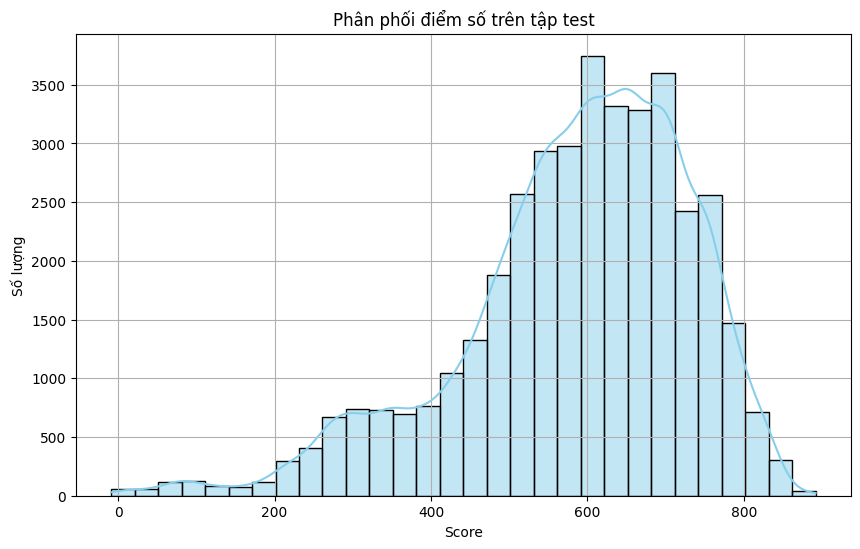

In [38]:
# 6. In phân phối điểm
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(test_scores['score'], bins=30, kde=True, color='skyblue')
plt.title('Phân phối điểm số trên tập test')
plt.xlabel('Score')
plt.ylabel('Số lượng')
plt.grid(True)
plt.show()

In [40]:
# CV Score
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, solver='lbfgs')

# KFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# CV AUC score trên dữ liệu WOE
auc_scores = cross_val_score(lr_model, X_train_woe, y_train_woe, cv=cv, scoring="roc_auc")
print("Cross-validation AUC:", auc_scores)
print("Mean AUC:", auc_scores.mean())


Cross-validation AUC: [0.89537405 0.8946764  0.90162977 0.90363449 0.89855179]
Mean AUC: 0.8987733004946813
